# Imports

In [1]:
import matplotlib.pyplot as plt
import spectral

from pathlib import Path
import numpy as np
import dask.array as da
from spectral import open_image, remove_continuum, kmeans

# Functions

In [2]:
def scale_image(img, crop_quantile=.05):
    lower = np.nanquantile(img, crop_quantile)
    upper = np.nanquantile(img, 1 - crop_quantile)

    scaled = img.copy()
    scaled[scaled > upper] = upper
    scaled[scaled < lower] = lower
    scaled -= np.nanmin(scaled)
    scaled /= np.nanmax(scaled)
    return scaled

# Get project

In [3]:
from hyperspec.from_napari_sediment.get_roi_and_mask import load_project_params

path_export_folder = Path(
    r"\\hlabstorage.dmz.marum.de\scratch\Yannick\hyperspec\iceland\qd_Geld_3.1_105-130cm_04082025_5_2025-08-04_12-24-46\napari_re"
)
params = load_project_params(path_export_folder)

# Get data

In [4]:
from hyperspec.from_napari_sediment.get_roi_and_mask import get_im_main_roi
from hyperspec.from_napari_sediment.get_roi_and_mask import get_mask_main

# passing mainroi_index=None gives the entire dataset
imcube = get_im_main_roi(path_export_folder, mainroi_index=0)
imcube = da.moveaxis(imcube, 0, -1)
mask = get_mask_main(path_export_folder)

img = open_image(params.file_path)
bands = np.array(img.bands.centers)
metadata = img.metadata
rgb_channels = np.array(metadata['default bands']).astype(int)

C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\.venv\Lib\site-packages\spectral\io\envi.py:187: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


`imcube` contains the entire dataset of the main roi. This accesses the calibrated data but it is important to use the `get_im_main_roi` for this. `img` is not using the calibrated data but provides access to the metadata 

In [5]:
print(type(imcube))
imcube

<class 'dask.array.core.Array'>


dask.array<transpose, shape=(7338, 481, 476), dtype=float32, chunksize=(500, 316, 1), chunktype=numpy.ndarray>

`img` is a connection to the raw file from the `spectral` library

In [6]:
print(type(img))
img

<class 'spectral.io.bilfile.BilFile'>


	Data Source:   '//hlabstorage.dmz.marum.de/scratch/Yannick/hyperspec/iceland/qd_Geld_3.1_105-130cm_04082025_5_2025-08-04_12-24-46/capture/qd_Geld_3.1_105-130cm_04082025_5_2025-08-04_12-24-46.raw'
	# Rows:           8343
	# Samples:        2184
	# Bands:           476
	Interleave:        BIL
	Quantization:  16 bits
	Data format:    uint16

In [7]:
print(type(metadata))
metadata.keys()

<class 'dict'>


dict_keys(['description', 'file type', 'sensor type', 'acquisition date', 'start time', 'stop time', 'samples', 'bands', 'lines', 'errors', 'interleave', 'data type', 'header offset', 'byte order', 'x start', 'y start', 'default bands', 'himg', 'vimg', 'hroi', 'vroi', 'fps', 'fps_qpf', 'tint', 'binning', 'binningaverage', 'trigger mode', 'trigger sync', 'fodis', 'sensorid', 'acquisitionwindow left', 'acquisitionwindow top', 'calibration pack', 'vnir temperature', 'scb temperature channel1', 'scb temperature channel2', 'scb temperature channel3', 'scb temperature channel4', 'temperature', 'wavelength', 'fwhm'])

## ROI

In [8]:
from hyperspec.from_napari_sediment.get_roi_and_mask import get_data_red_roi, get_data_red_roi_from_extent

# if this is set to False, will attempt to use the ROI exported from napari-sediment
get_red_roi_manually = False

# perform mnf on masked subsection
print('obtaining roi')

if get_red_roi_manually:
    # row_start, row_end, col_start, col_end
    width_roi = 20
    row_start = 0
    row_end = imcube.shape[0]
    col_start = round(imcube.shape[1] / 2 - width_roi / 2)
    col_end = col_start + width_roi
    row_bounds_relative_to_main = [row_start, row_end, col_start, col_end]
    roi, mask_valid_roi = get_data_red_roi_from_extent(imcube, params, *row_bounds_relative_to_main, True)
    roi = np.asarray(roi)
else:
    roi, mask_valid_roi = get_data_red_roi(imcube, params, True)
    roi = np.asarray(roi)

obtaining roi
obtaining roi_height=np.int64(7338) x roi_width=np.int64(20) x n_channels=476 datapoints
done obtaining data


In [9]:
print(f'creating RGB images with wavelengths {dict(zip('RGB', bands[rgb_channels]))}')
rgb_img = imcube[:, :, rgb_channels].compute()
rgb_roi = roi[:, :, rgb_channels]

creating RGB images with wavelengths {'R': np.float64(646.51), 'G': np.float64(553.12), 'B': np.float64(475.44)}


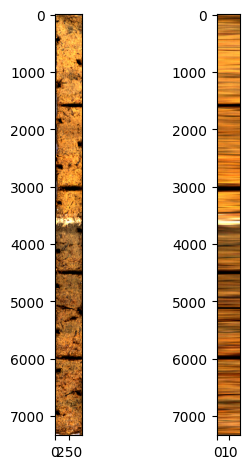

In [10]:
### plot imcube and ROI
fig, axs = plt.subplots(nrows=1, ncols=2, layout='tight')

axs[0].imshow(scale_image(rgb_img))
axs[1].imshow(scale_image(rgb_roi), aspect=1 / 20)

## Convex hull for continnum removal

Text(0.5, 0, 'Wavelength (nm)')

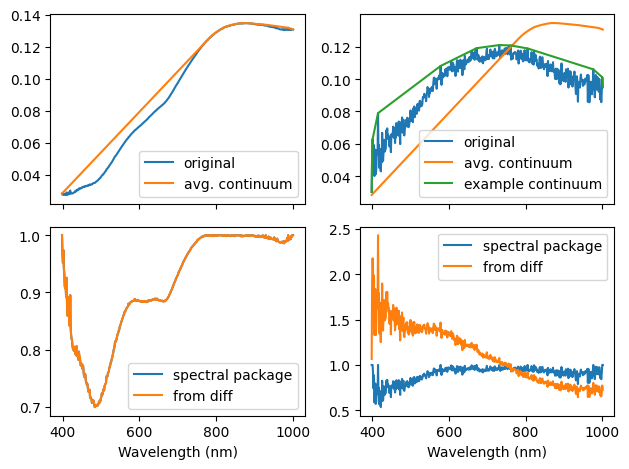

In [399]:
from spectral import continuum_points

spec = roi.mean(axis=(0, 1))
cont_points = continuum_points(spec, bands)
spec_cont = np.interp(bands, cont_points[0], cont_points[1])
spec_cont_removed = remove_continuum(spec, bands)

def remove_avg_continuum(arr):
    return 1 - (spec_cont - arr) / spec_cont

def add_avg_continuum(arr):
    return spec_cont * arr

diff = remove_avg_continuum(spec)
example_spec = roi[roi.shape[0] // 2, roi.shape[1] // 2, :]

fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, layout='tight')
axs[0, 0].plot(bands, spec, label='original')
axs[0, 0].plot(bands, spec_cont, label='avg. continuum')
axs[0, 0].legend()

axs[0, 1].plot(bands, example_spec, label='original')
axs[0, 1].plot(bands, spec_cont, label='avg. continuum')
axs[0, 1].plot(*continuum_points(example_spec, bands), label='example continuum')
axs[0, 1].legend()

axs[1, 0].plot(bands, spec_cont_removed, label='spectral package')
axs[1, 0].plot(bands, diff, label='from diff')
axs[1, 0].legend()
axs[1, 0].set_xlabel('Wavelength (nm)')

axs[1, 1].plot(bands, remove_continuum(example_spec, bands), label='spectral package')
axs[1, 1].plot(bands, remove_avg_continuum(example_spec), label='from diff')
axs[1, 1].legend()
axs[1, 1].set_xlabel('Wavelength (nm)')


# Spectral analysis on reduced data

mnf and PPI can be performed with `napari-sediment` as well but we lack some of the flexibility that we would like to have. Since it is based on the `spectral` library, we can make those calls here explicitly.

## MNF

In [11]:
print('calcing stats ...')
signal = spectral.calc_stats(roi, mask_valid_roi[:, :, 0])
print('calcing noise ...')
noise = spectral.noise_from_diffs(roi)
print('calcing nmf ...')
mnfr = spectral.mnf(signal, noise)

calcing stats ...
calcing noise ...
calcing nmf ...


In [12]:
signal.cov.shape

(476, 476)

plot some of the eigenvectors (in columns according to documentation)

creating plot ...


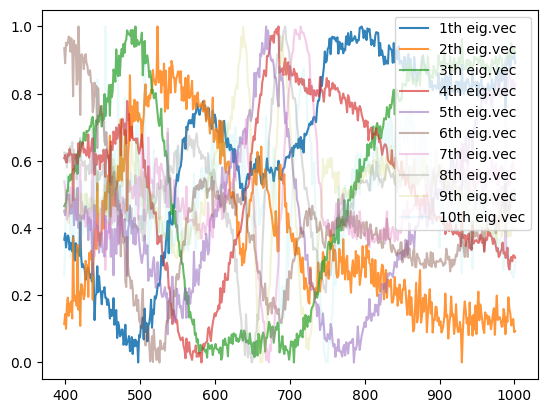

In [13]:
print('creating plot ...')
n_vecs = 10
plt.figure()
lams = img.bands.centers
for i in range(n_vecs):
    v = mnfr.napc.eigenvectors[:, i].copy()
    v -= v.min()
    v /= v.max()
    plt.plot(lams, v, alpha=1 - (i + 1) / (n_vecs + 1), label=f'{i + 1}th eig.vec')
plt.legend()

plot eigenvalues

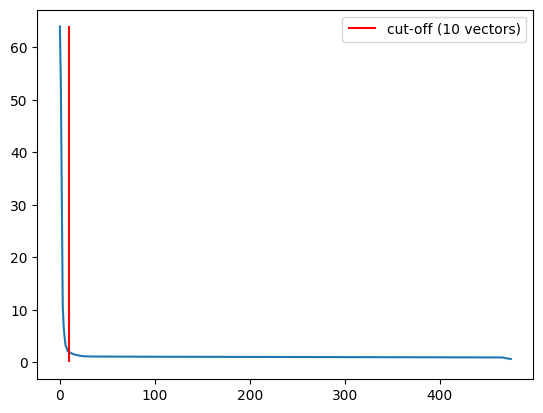

In [14]:
plt.plot(mnfr.napc.eigenvalues)
plt.vlines(n_vecs, 0, mnfr.napc.eigenvalues.max(), colors='red', label=f'cut-off ({n_vecs} vectors)')
plt.legend()

In [15]:
# De-noise the data by eliminating NAPC components where SNR < 10.
# The de-noised data will be in the original coordinate space (at
# full dimensionality).
print('denoising ...')
denoised_mnf = mnfr.denoise(roi, num=n_vecs)

denoising ...


### understanding forward and backward reduction

In [16]:
# T = A^T * Z where Z is the zero-meaned data and A is the solution of the generalized eigenvalue problem

def get_denoised(some_data, mnf_result, N):
    V = mnf_result.napc.eigenvectors
    # nullify all compounds over N
    Vr = np.array(V)
    Vr[:, N:] = 0.
    D = mnf_result.noise.sqrt_cov.dot(Vr) @ (V.T) @ (mnf_result.noise.sqrt_inv_cov)

    return D @ some_data


V = mnfr.napc.eigenvectors
# nullify all compounds over N
Vr = np.array(V)
Vr[:, n_vecs:] = 0.
D = mnfr.noise.sqrt_cov @ Vr @ V.T @ mnfr.noise.sqrt_inv_cov


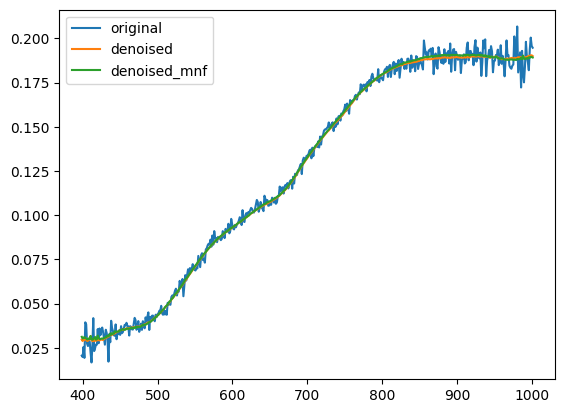

In [17]:
i, j = np.random.choice(np.arange(roi.shape[0])), np.random.choice(np.arange(roi.shape[1]))
plt.plot(bands, roi[i, j, :], label='original')
plt.plot(bands, (D @ roi[i, j, :]), label='denoised')
plt.plot(bands, (denoised_mnf[i, j, :]), label='denoised_mnf')
plt.legend()

### Reduce dimensionality, retaining top NAPC components.

In [18]:
reduced = mnfr.reduce(roi, num=n_vecs)

In [19]:
reduced.shape

(7338, 20, 10)

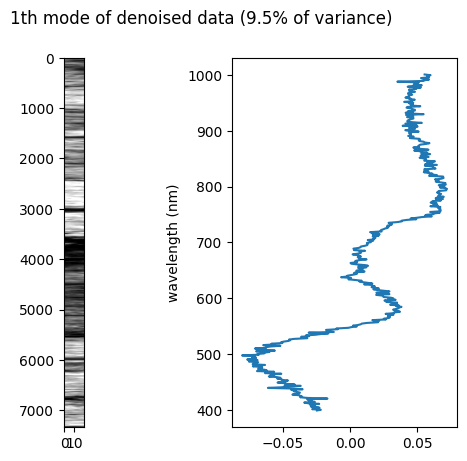

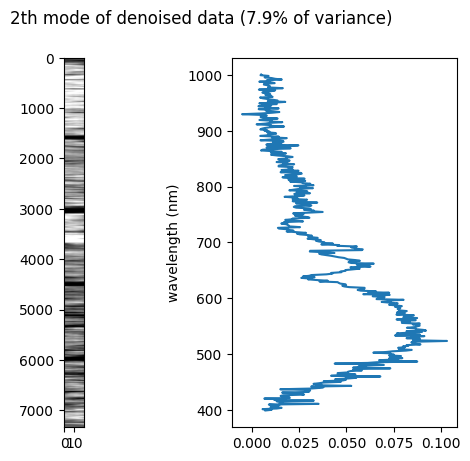

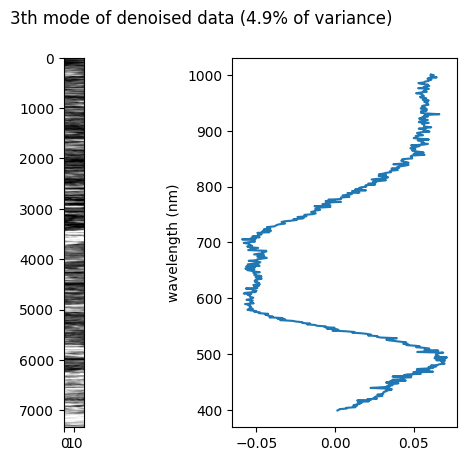

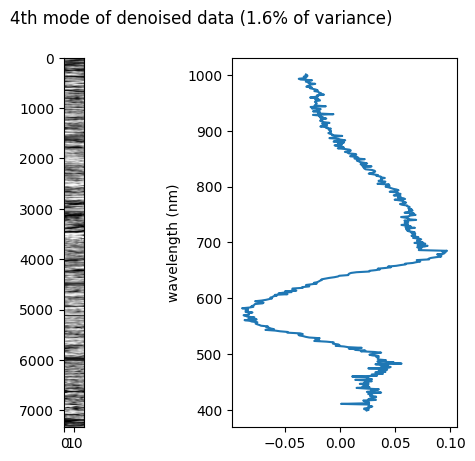

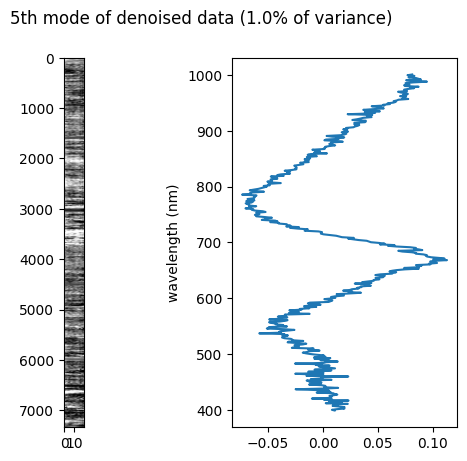

In [20]:
for i in range(min([n_vecs, 5])):
    fig, axs = plt.subplots(ncols=2)
    img = reduced[:, :, i]
    axs[0].imshow(img, vmin=np.quantile(img, .05), vmax=np.quantile(img, .95), aspect=1 / 20, cmap='grey')
    axs[1].plot(mnfr.napc.eigenvectors[:, i], lams)
    axs[1].set_ylabel('wavelength (nm)')
    fig.suptitle(
        f'{i + 1}th mode of denoised data ({mnfr.napc.eigenvalues[i] / mnfr.napc.eigenvalues.sum():.1%} of variance)')

## endmember idenfitication

### pixel purity index

Running 1000 pixel purity iterations...done   


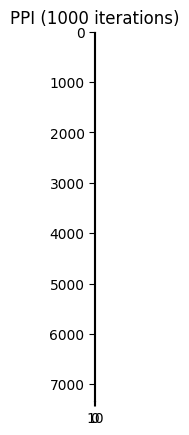

In [152]:
from scipy.signal import savgol_filter

n_iters_ppi = 1000
counts = spectral.algorithms.ppi(reduced, niters=n_iters_ppi, centered=False, display=1)

In [184]:
# number of counts
thr_counts = n_iters_ppi / 30
mask_ppi = counts > thr_counts
endmembers = denoised_mnf[mask_ppi]
print(f'detected {endmembers.shape[0]} endmembers')

detected 5 endmembers


(np.uint32(0), np.uint32(61), np.float64(0.01362769146906514))

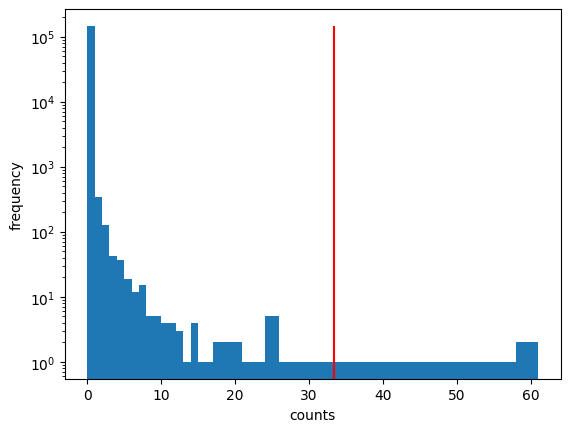

In [189]:
# how are counts distributed? ideally we have few pixels with high counts
ret = plt.hist(counts.ravel(), bins=np.unique(counts), log=True)
plt.vlines(thr_counts, 0, ret[0].max(), colors='red')
plt.xlabel('counts')
plt.ylabel('frequency')
counts.min(), counts.max(), counts.mean()

Text(0.5, 0, 'Wavelength (nm)')

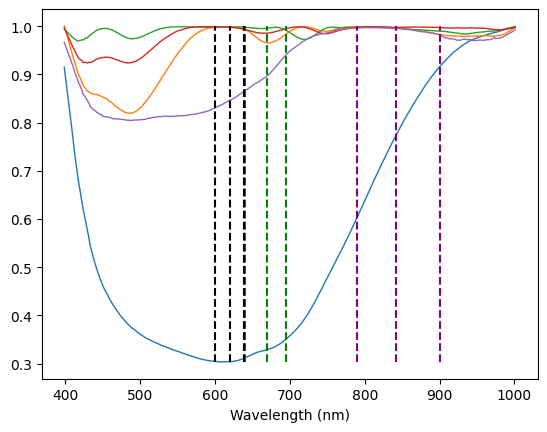

In [190]:
a = np.inf
b = -np.inf
for i in range(endmembers.shape[0]):
    y = remove_continuum(endmembers[i, :], bands=bands)
    y = savgol_filter(y, window_length=21, polyorder=1)
    if y.min() < a:
        a = y.min()
    if y.max() > b:
        b = y.max()
    plt.plot(bands, y, linewidth=1)
# Chl-a trough
plt.vlines([640, 670, 695], a, b, linestyles='--', colors='green')
#BChl-a trough
plt.vlines([790, 900, 842], a, b, linestyles='--', colors='purple')
# Phycocyanin trough
plt.vlines([620, 639, 600], a, b, linestyles='--', colors='black')
plt.xlabel('Wavelength (nm)')

### K-means

In [250]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import math

kmeans_on_denoised = True
kmeans_on_reduced = True
kmeans_on_normalized = True  # continuum contains information of total reflectance, which is useful information


def get_reduced_and_normalized(data):
    if kmeans_on_denoised:
        # assert not (kmeans_on_reduced or kmeans_on_normalized)
        data = mnfr.denoise(data, num=n_vecs)
    if kmeans_on_normalized:
        data = remove_continuum(data, bands=bands)
        # data = remove_avg_continuum(data)
        # data /= data.mean(axis=(0, 1))
    if kmeans_on_reduced:
        data = mnfr.reduce(data, num=n_vecs)
    return data


data_kmeans = get_reduced_and_normalized(roi)
data_kmeans[np.isnan(data_kmeans)] = 0
# reshape and mask
X_kmeans = data_kmeans[mask_valid_roi[:, :, 0]]

Text(0.5, 0, 'MNF dimension')

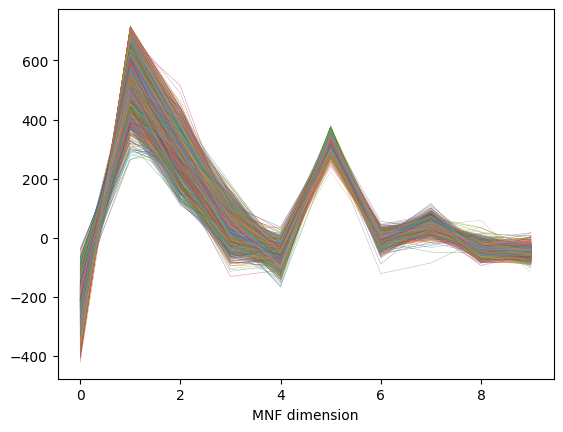

In [251]:
# make sure our X looks somewhat reasonable
n_test = 2000

for i in np.random.choice(range(X_kmeans.shape[0]), n_test, replace=False):
    plt.plot(X_kmeans[i, :], linewidth=.2)
plt.xlabel('MNF dimension')


#### find right number of clusters via silhoutte coefficient

In [252]:
from sklearn.metrics import silhouette_score

n_clusters_max = 10
clusters_to_test = np.arange(2, n_clusters_max + 1)

print('starting silhoutte calculation')
res = {}
for n_clusters in clusters_to_test:
    kmeans_sk = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans_sk.fit_predict(X_kmeans)
    silhouette_avg = silhouette_score(X_kmeans, cluster_labels, sample_size=1000)
    res[n_clusters] = (silhouette_avg, kmeans_sk)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

starting silhoutte calculation
For n_clusters = 2 The average silhouette_score is : 0.3306668766575103
For n_clusters = 3 The average silhouette_score is : 0.28104339454675253
For n_clusters = 4 The average silhouette_score is : 0.2676585047051324
For n_clusters = 5 The average silhouette_score is : 0.25635225673832207
For n_clusters = 6 The average silhouette_score is : 0.23126438957349857
For n_clusters = 7 The average silhouette_score is : 0.23345582339335516
For n_clusters = 8 The average silhouette_score is : 0.19986767489135457
For n_clusters = 9 The average silhouette_score is : 0.20778174453160245
For n_clusters = 10 The average silhouette_score is : 0.20441394385884726


In [253]:
# we want the highest silhoutte coefficient
idx = np.argmax([r[0] for r in res.values()])
# n_clusters_best = clusters_to_test[idx]
n_clusters_best = 4
kmeans_sk = res[n_clusters_best][1]
print(f'the highest scoring option is {n_clusters_best} clusters')

the highest scoring option is 4 clusters


In [254]:
# already fitted, so we can just predict (even the holes
labels = kmeans_sk.predict(data_kmeans.reshape(math.prod(reduced.shape[:2]), -1)).reshape(reduced.shape[:2])

In [255]:
# add new label for holes
# for ngist colormap it makes sense to set this label to the highest value since it appears as white
labels[~mask_valid_roi[:, :, 0]] = labels.max() + 1
u_labels = np.unique(labels)
n_labels = len(u_labels)

# use denoised (and normalized) to recalculate cluster centers
centers_kmeans = np.zeros((n_labels, roi.shape[2]))

if kmeans_on_normalized:
    for_centers = remove_continuum(roi, bands=bands)
else:
    for_centers = roi

for i, l in enumerate(u_labels):
    mask_label = labels == l
    centers_kmeans[i, :] = for_centers[mask_label, :].mean(axis=0)

C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\.venv\Lib\site-packages\spectral\algorithms\continuum.py:221: RuntimeWarning: invalid value encountered in divide
  out[i, j, :] /= continuum


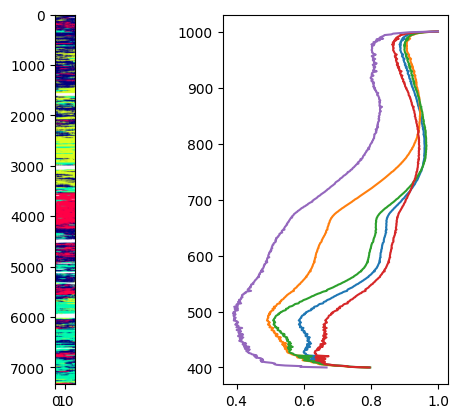

In [256]:
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(labels, aspect=1 / 20, cmap='gist_ncar')
for i in range(centers_kmeans.shape[0]):
    axs[1].plot(centers_kmeans[i, :], bands)

#### extent kmeans annotations to entire image

In [257]:
print('this will take a while and a lot of memory ...')
print('converting to np array ...')
imcube_for_pred = np.asarray(imcube, dtype=float)
if kmeans_on_normalized:
    print('removing continuum ...')
    imcube_for_pred = remove_continuum(imcube_for_pred, bands=bands)
    if kmeans_on_reduced:
        print('reducing ...')
        imcube_for_pred = mnfr.reduce(imcube_for_pred, num=n_vecs)
elif kmeans_on_reduced:
    print('reducing ...')
    imcube_for_pred = mnfr.reduce(imcube_for_pred, num=n_vecs)
imcube_for_pred[np.isnan(imcube_for_pred)] = 0
print('Done!')

this will take a while and a lot of memory ...
converting to np array ...
removing continuum ...
reducing ...
Done!


make sure spectra in imcube look similar to those of the ROI used to fit K-Means

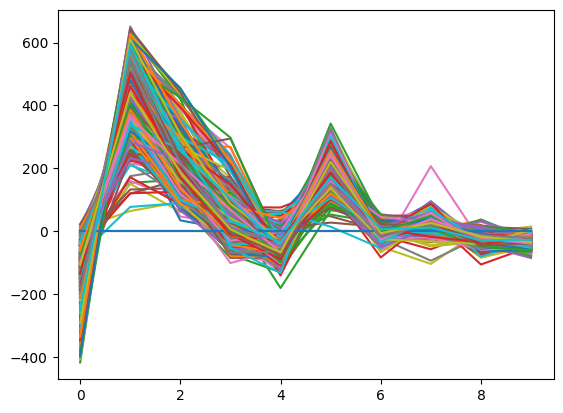

In [258]:
n_test = 1000
random_indices = list(zip(
    np.random.choice(np.arange(imcube_for_pred.shape[0]), size=n_test),
    np.random.choice(np.arange(imcube_for_pred.shape[1]), size=n_test)
))

for i, j in random_indices:
    spec = imcube_for_pred[i, j, :]
    plt.plot(spec)

In [259]:
from tqdm import tqdm

ncols, nrows = imcube.shape[:2]

I, J = np.meshgrid(range(ncols), range(nrows))
ij = zip(I.ravel(), J.ravel())

if not kmeans_on_reduced:
    print('only works for not reduced, would need some other method otherwise')

labels_full = np.zeros((ncols, nrows))

label_invalid = labels.max()
for i, j in tqdm(ij, total=ncols * nrows):
    if mask[i, j]:
        labels_full[i, j] = label_invalid
    else:
        labels_full[i, j] = kmeans_sk.predict(imcube_for_pred[i, j, :].reshape(1, -1))[0]

100%|██████████| 3529578/3529578 [02:11<00:00, 26937.63it/s]


In [260]:
np.unique(labels_full, return_counts=True)

(array([0., 1., 2., 3., 4.]),
 array([ 305955,  656862, 2075333,  100276,  391152]))

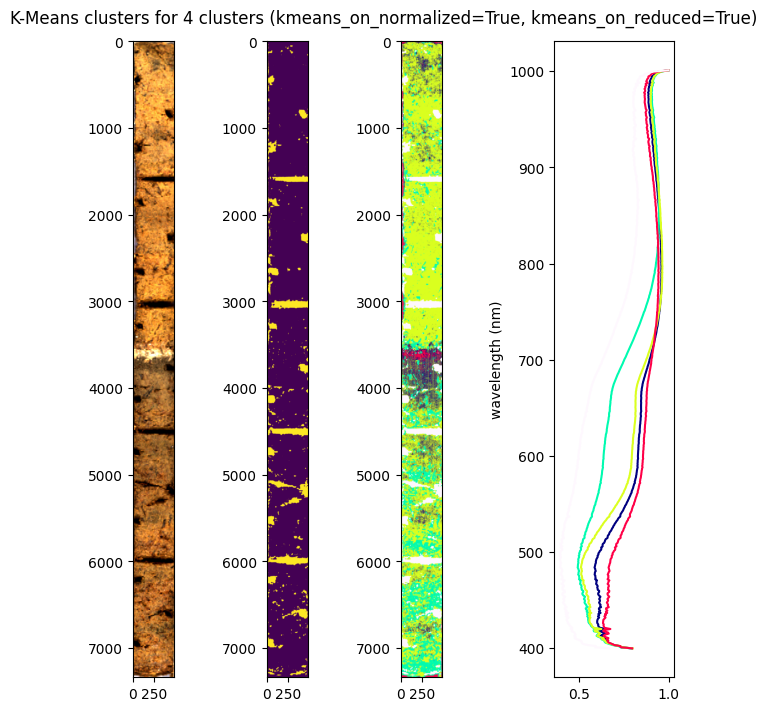

In [261]:
import matplotlib

remove_continuum_if_not_on_normalized = False

fig, axs = plt.subplots(ncols=4, sharey=False, layout='constrained', figsize=(6, 7))
axs[0].imshow(scale_image(rgb_img))
axs[1].imshow(mask)
axs[2].imshow(labels_full, cmap='gist_ncar')

cmap = matplotlib.colormaps['gist_ncar']
n_centers = centers_kmeans.shape[0]
for i in range(n_centers):
    y = centers_kmeans[i, :]
    if remove_continuum_if_not_on_normalized and (not kmeans_on_normalized):
        y = remove_continuum(y, bands=bands)
    axs[3].plot(y, bands, c=cmap(i / (n_centers - 1)))

# add bars for rgb channels
wl_rgb = bands[rgb_channels]
# axs[3].hlines(wl_rgb, 0, centers_kmeans.max, colors=['r', 'g', 'b'])

axs[3].set_ylabel('wavelength (nm)')
axs[3].set_title('')
fig.suptitle(f'K-Means clusters for {n_clusters_best} clusters ({kmeans_on_normalized=}, {kmeans_on_reduced=})')
fig.savefig('clusters.pdf')

### VCA

In [37]:
# https://github.com/Laadr/VCA.git
import sys
import numpy as np


def estimate_snr(Y, r_m, x):
    [L, N] = Y.shape  # L number of bands (channels), N number of pixels
    [p, N] = x.shape  # p number of endmembers (reduced dimension)

    P_y = np.sum(Y ** 2) / float(N)
    P_x = np.sum(x ** 2) / float(N) + np.sum(r_m ** 2)
    snr_est = 10 * np.log10((P_x - p / L * P_y) / (P_y - P_x))

    return snr_est


def vca(Y, R, verbose=True, snr_input=0):
    # Vertex Component Analysis
    #
    # Ae, indice, Yp = vca(Y,R,verbose = True,snr_input = 0)
    #
    # ------- Input variables -------------
    #  Y - matrix with dimensions L(channels) x N(pixels)
    #      each pixel is a linear mixture of R endmembers
    #      signatures Y = M x s, where s = gamma x alfa
    #      gamma is a illumination perturbation factor and
    #      alfa are the abundance fractions of each endmember.
    #  R - positive integer number of endmembers in the scene
    #
    # ------- Output variables -----------
    # Ae     - estimated mixing matrix (endmembers signatures)
    # indice - pixels that were chosen to be the most pure
    # Yp     - Data matrix Y projected.
    #
    # ------- Optional parameters---------
    # snr_input - (float) signal to noise ratio (dB)
    # v         - [True | False]
    # ------------------------------------
    #
    # Author: Adrien Lagrange (adrien.lagrange@enseeiht.fr)
    # This code is a translation of a matlab code provided by
    # Jose Nascimento (zen@isel.pt) and Jose Bioucas Dias (bioucas@lx.it.pt)
    # available at http://www.lx.it.pt/~bioucas/code.htm under a non-specified Copyright (c)
    # Translation of last version at 22-February-2018 (Matlab version 2.1 (7-May-2004))
    #
    # more details on:
    # Jose M. P. Nascimento and Jose M. B. Dias
    # "Vertex Component Analysis: A Fast Algorithm to Unmix Hyperspectral Data"
    # submited to IEEE Trans. Geosci. Remote Sensing, vol. .., no. .., pp. .-., 2004
    #
    #

    #############################################
    # Initializations
    #############################################
    if len(Y.shape) != 2:
        sys.exit('Input data must be of size L (number of bands i.e. channels) by N (number of pixels)')

    [L, N] = Y.shape  # L number of bands (channels), N number of pixels

    R = int(R)
    if (R < 0 or R > L):
        sys.exit('ENDMEMBER parameter must be integer between 1 and L')

    #############################################
    # SNR Estimates
    #############################################

    if snr_input == 0:
        y_m = np.mean(Y, axis=1, keepdims=True)
        Y_o = Y - y_m  # data with zero-mean
        Ud = np.linalg.svd(np.dot(Y_o, Y_o.T) / float(N))[0][:, :R]  # computes the R-projection matrix
        x_p = np.dot(Ud.T, Y_o)  # project the zero-mean data onto p-subspace

        SNR = estimate_snr(Y, y_m, x_p);

        if verbose:
            print("SNR estimated = {}[dB]".format(SNR))
    else:
        SNR = snr_input
        if verbose:
            print("input SNR = {}[dB]\n".format(SNR))

    SNR_th = 15 + 10 * np.log10(R)

    #############################################
    # Choosing Projective Projection or
    #          projection to p-1 subspace
    #############################################

    if SNR < SNR_th:
        if verbose:
            print("... Select proj. to R-1")

        d = R - 1
        if snr_input == 0:  # it means that the projection is already computed
            Ud = Ud[:, :d]
        else:
            y_m = np.mean(Y, axis=1, keepdims=True)
            Y_o = Y - y_m  # data with zero-mean

            Ud = np.linalg.svd(np.dot(Y_o, Y_o.T) / float(N))[0][:, :d]  # computes the p-projection matrix
            x_p = np.dot(Ud.T, Y_o)  # project thezeros mean data onto p-subspace

        Yp = np.dot(Ud, x_p[:d, :]) + y_m  # again in dimension L

        x = x_p[:d, :]  #  x_p =  Ud.T * Y_o is on a R-dim subspace
        c = np.amax(np.sum(x ** 2, axis=0)) ** 0.5
        y = np.vstack((x, c * np.ones((1, N))))
    else:
        if verbose:
            print("... Select the projective proj.")

        d = R
        Ud = np.linalg.svd(np.dot(Y, Y.T) / float(N))[0][:, :d]  # computes the p-projection matrix

        x_p = np.dot(Ud.T, Y)
        Yp = np.dot(Ud, x_p[:d, :])  # again in dimension L (note that x_p has no null mean)

        x = np.dot(Ud.T, Y)
        u = np.mean(x, axis=1, keepdims=True)  #equivalent to  u = Ud.T * r_m
        y = x / (np.dot(u.T, x) + 1e-7)

    #############################################
    # VCA algorithm
    #############################################

    indice = np.zeros((R), dtype=int)
    A = np.zeros((R, R))
    A[-1, 0] = 1

    for i in range(R):
        w = np.random.rand(R, 1)
        f = w - np.dot(A, np.dot(np.linalg.pinv(A), w))
        f = f / np.linalg.norm(f)

        v = np.dot(f.T, y)

        indice[i] = np.argmax(np.absolute(v))
        A[:, i] = y[:, indice[i]]  # same as x(:,indice(i))

    Ae = Yp[:, indice]

    return Ae, indice, Yp

In [38]:
n_endmembers_vca = 5

X_vca = roi.reshape((-1, roi.shape[-1]))  # squish pixel dims
# TODO: what is X_projected? is it usefull?
endmembers_vca, indices_vca, X_projected = vca(X_vca.T, R=n_endmembers_vca)

SNR estimated = 28.900964736938477[dB]
... Select the projective proj.


Text(0.5, 0, 'Wavelength (nm)')

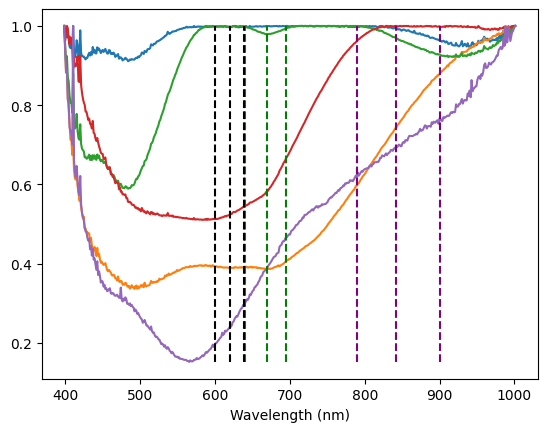

In [39]:
vca_normalize_for_plot = True
vca_smooth_for_plot = False

a = np.inf
b = -np.inf
for i in range(n_endmembers_vca):
    y = endmembers_vca[:, i]
    if vca_smooth_for_plot:
        y = savgol_filter(y, window_length=21, polyorder=1)
    if vca_normalize_for_plot:
        y = remove_continuum(y, bands=bands)
    if y.min() < a:
        a = y.min()
    if y.max() > b:
        b = y.max()
    plt.plot(bands, y)
plt.xlabel('Wavelength (nm)')
# Chl-a trough
plt.vlines([640, 670, 695], a, b, linestyles='--', colors='green')
#BChl-a trough
plt.vlines([790, 900, 842], a, b, linestyles='--', colors='purple')
# Phycocyanin trough
plt.vlines([620, 639, 600], a, b, linestyles='--', colors='black')
plt.xlabel('Wavelength (nm)')

In [40]:
endmembers.shape, X_kmeans.shape

((5, 476), (139185, 10))

## Spline coefficients

In [41]:
normalize_for_spline_coeffs: bool = True

In [263]:
print('converting image cube to np array ...')
imcube_for_nmf = np.asarray(imcube, dtype=float)
if normalize_for_spline_coeffs:
    print('normalizing ...')
    # imcube_for_nmf = remove_continuum(imcube_for_nmf, bands=bands)
    imcube_for_nmf = remove_avg_continuum(imcube_for_nmf)
print('done!')

converting image cube to np array ...
normalizing ...
done!


In [265]:
imcube_for_nmf.min(), imcube_for_nmf.max()

(np.float64(0.0), np.float64(7.046722652047851))

In [43]:
# imcube_for_nmf[np.isnan(imcube_for_nmf)] = 1

#### get matrix of Bspline coefficients

In [310]:
from scipy.interpolate import make_lsq_spline, BSpline

# find knots
DEGREE = 3
# knots = [490, 580,  670, 800, 900]
knots = np.arange(400, 1000 + 50, 50)[1:-1]
# knots_padded = pad_knots_by_deg(knots, DEGREE)
knots_padded = np.r_[(bands[0],) * (DEGREE + 1), knots, (bands[-1],) * (DEGREE + 1)]

In [311]:
# find b-spline coefficients
spl_coeffs_imcube = []

# ravel image dimension
n_rows, n_cols = imcube_for_nmf.shape[:2]
n_pixels = n_rows * n_cols

for i1d in tqdm(range(n_pixels), total=n_pixels, desc='calcing B-spline coefficients'):
    i, j = np.unravel_index(i1d, (n_rows, n_cols))
    y = imcube_for_nmf[i, j, :]
    spl = make_lsq_spline(bands, y, t=knots_padded, k=DEGREE)
    spl_coeffs_imcube.append(spl.c)
spl_coeffs_imcube = np.array(spl_coeffs_imcube)

calcing B-spline coefficients: 100%|██████████| 3529578/3529578 [04:53<00:00, 12012.08it/s]


In [316]:
spl_coeffs_imcube.shape, (spl_coeffs_imcube < 0).sum(), spl_coeffs_imcube.min()

((3529578, 15), np.int64(1255), np.float64(-0.20648927650108506))

Text(0.5, 0, 'Wavelength (nm)')

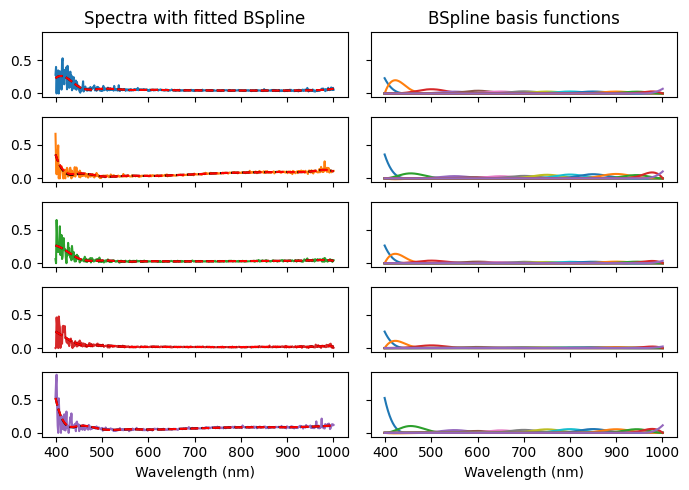

In [321]:
n_bsplines_plot = 5
idcs_plot = np.random.choice(np.arange(spl_coeffs_imcube.shape[0]), n_bsplines_plot)

# plot some with negative indices
_mask_neg = np.any(spl_coeffs_imcube < 0, axis=1)
idcs_plot = np.arange(spl_coeffs_imcube.shape[0])[_mask_neg]

if _mask_neg.sum() > n_bsplines_plot:
    idcs_plot = np.random.choice(idcs_plot, n_bsplines_plot)

fig, axs = plt.subplots(nrows=n_bsplines_plot, ncols=2, sharex=True, sharey=True, figsize=(7, n_bsplines_plot), layout='tight')
for plt_idx, k in enumerate(idcs_plot):
    # i, j = np.random.choice(np.arange(n_rows)), np.random.choice(np.arange(n_cols))
    i, j = divmod(k, imcube_for_nmf.shape[1])
    y = imcube_for_nmf[i, j, :]
    # spl = make_lsq_spline(bands, y, t=knots_padded, k=DEGREE)
    coeffs = spl_coeffs_imcube[k]
    coeffs_tapered = coeffs.copy()
    coeffs_tapered[coeffs_tapered < 0] = 0
    spl = BSpline(t=knots_padded, k=DEGREE, c=coeffs)
    spl_tapered = BSpline(t=knots_padded, k=DEGREE, c=coeffs_tapered)
    axs[plt_idx, 0].plot(bands, y, c=f'C{plt_idx}')
    axs[plt_idx, 0].plot(bands, spl(bands), c='black', linestyle='--')
    axs[plt_idx, 0].plot(bands, spl_tapered(bands), c='red', linestyle='--')

    for l in range(spl_coeffs_imcube.shape[1]):
        _mask = np.zeros_like(coeffs)
        _mask[l] = 1
        _spl = BSpline(t=knots_padded, k=DEGREE, c=coeffs * _mask)
        axs[plt_idx, 1].plot(bands, _spl(bands), c=f'C{l}')
axs[0, 0].set_title('Spectra with fitted BSpline')
axs[0, 1].set_title('BSpline basis functions')
axs[-1, 0].set_xlabel('Wavelength (nm)')
axs[-1, 1].set_xlabel('Wavelength (nm)')

In [322]:
spl_coeffs_imcube_pos = spl_coeffs_imcube.copy()
spl_coeffs_imcube_pos[spl_coeffs_imcube_pos < 0] = 0

## PCA on spline coefficients

In [492]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=.99)
pca_model.fit(spl_coeffs_imcube_pos[mask.ravel() > 0])
X_pca = pca_model.transform(spl_coeffs_imcube_pos)

In [493]:
X_pca.shape

(3529578, 5)

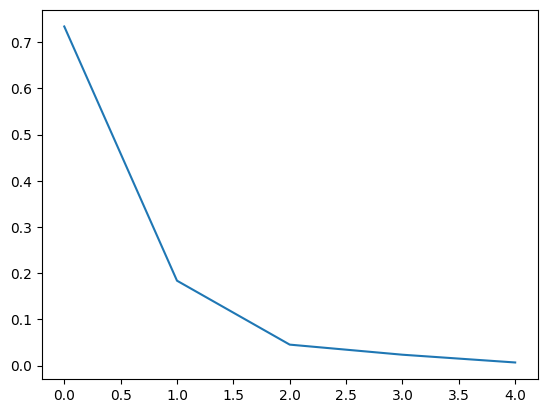

In [324]:
plt.plot(pca_model.explained_variance_ratio_)

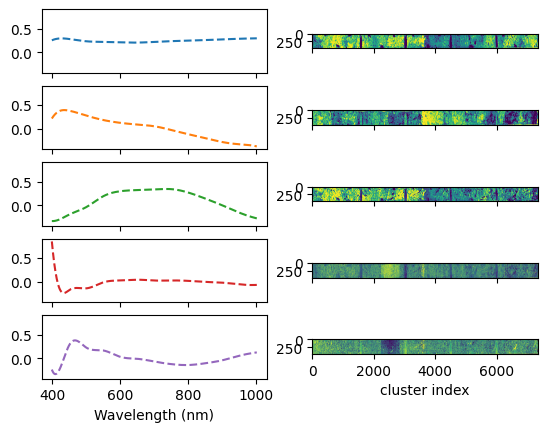

In [495]:
n_inner = X_pca.shape[1]

fig, axs = plt.subplots(ncols=2, nrows=n_inner, sharex='col', sharey='col')

for i in range(n_inner):
    spl_nmf = BSpline(c=pca_model.components_[i, :], t=knots_padded, k=DEGREE)
    spec_normed = spl_nmf(bands)
    # spec = add_avg_continuum(spec_normed)
    # axs[i, 0].plot(bands, spec_normed, c=f'C{i}', linestyle='--')
    axs[i, 0].plot(bands, spec_normed, c=f'C{i}', linestyle='--')
    # axs[i, 0].plot(bands, remove_continuum(spec, bands), c=f'C{i}', linestyle='--')
    axs[i, 1].imshow(scale_image(X_pca[:, i].reshape((imcube.shape[:2])).T))
axs[-1, 0].set_xlabel('Wavelength (nm)')
axs[-1, 1].set_xlabel('cluster index')
fig.savefig('nmf.png', dpi=600)

Text(0.5, 1.0, 'Eigenvectors of imcube (fitted on B-spline coefficients)')

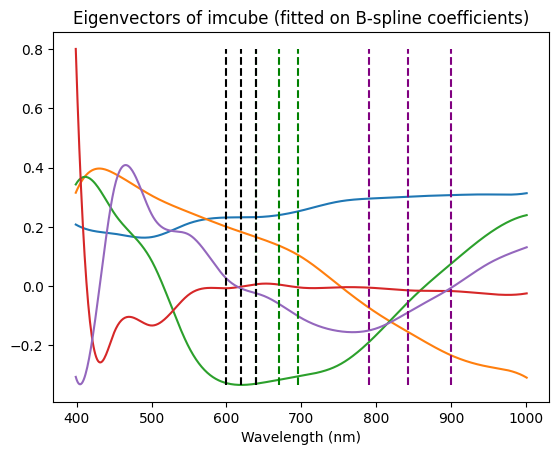

In [487]:
# eigenvectors are rows in
a = np.inf
b = -np.inf
for i in range(pca_model.components_.shape[0]):
    coeffs = pca_model.components_[i, :]
    spl = BSpline(t=knots_padded, k=DEGREE, c=coeffs)
    y = spl(bands)
    plt.plot(bands, y, c=f'C{i}', label=f'PC{i+1}')
    if y.min() < a:
        a = y.min()
    if y.max() > b:
        b = y.max()

plt.xlabel('Wavelength (nm)')
plt.vlines([640, 670, 695], a, b, linestyles='--', colors='green')
#BChl-a trough
plt.vlines([790, 900, 842], a, b, linestyles='--', colors='purple')
# Phycocyanin trough
plt.vlines([620, 639, 600], a, b, linestyles='--', colors='black')
plt.title('Eigenvectors of imcube (fitted on B-spline coefficients)')

## NMF on spline coefficients

In [335]:
spl_coeffs_imcube_pos.shape

(3529578, 15)

In [445]:
# select subset of pixels to use for fitting
idcs = np.arange(spl_coeffs_imcube_pos.shape[0])[mask.ravel() == 0]
idcs = np.random.choice(idcs, size=spl_coeffs_imcube_pos.shape[0] // 5, replace=False)

In [446]:
idcs

array([1176325, 1109454, 3469610, ..., 1959416, 2478953,  153526],
      shape=(705915,))

(np.int64(705915), 1764789)

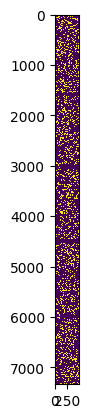

In [447]:
selected = np.zeros(imcube_for_nmf.shape[:2], dtype=bool)
selected.ravel()[idcs] = True
plt.imshow(selected, interpolation='none')

In [457]:
from sklearn.decomposition import NMF
# no regularization on loadings (images)
model = NMF(max_iter=1000, init='nndsvda', n_components=7, alpha_W=0)
# model = NMF(max_iter=10000, init='random', n_components=4)

X = spl_coeffs_imcube_pos[idcs, :]
model.fit(X)

,n_components,7
,init,'nndsvda'
,solver,'cd'
,beta_loss,'frobenius'
,tol,0.0001
,max_iter,1000
,random_state,None
,alpha_W,0
,alpha_H,'same'
,l1_ratio,0.0
,verbose,0


In [458]:
model.reconstruction_err_

np.float64(63.59085605094613)

In [459]:
W = model.transform(spl_coeffs_imcube_pos)
H = model.components_

In [460]:
W.shape, H.shape, X.shape

((3529578, 7), (7, 15), (705915, 15))

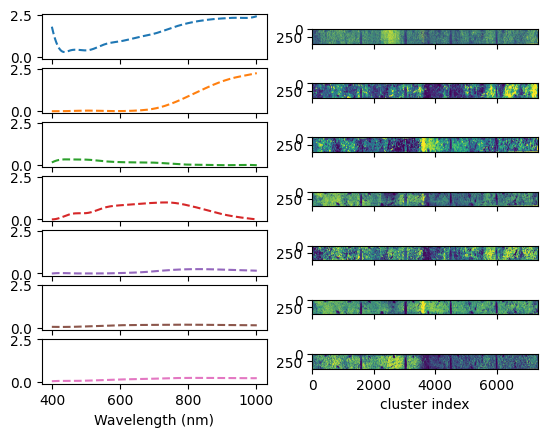

In [466]:
n_inner = W.shape[1]

fig, axs = plt.subplots(ncols=2, nrows=n_inner, sharex='col', sharey='col')

for i in range(n_inner):
    spl_nmf = BSpline(c=H[i, :], t=knots_padded, k=DEGREE)
    spec_normed = spl_nmf(bands)
    spec = add_avg_continuum(spec_normed)
    # axs[i, 0].plot(bands, spec_normed, c=f'C{i}', linestyle='--')
    axs[i, 0].plot(bands, spec, c=f'C{i}', linestyle='--')
    # axs[i, 0].plot(bands, remove_continuum(spec, bands), c=f'C{i}', linestyle='--')
    axs[i, 1].imshow(scale_image(W[:, i].reshape((imcube.shape[:2])).T))
axs[-1, 0].set_xlabel('Wavelength (nm)')
axs[-1, 1].set_xlabel('cluster index')
fig.savefig('nmf.png', dpi=600)

## Spectral indices

In [468]:
def get_img_for_wavelength(lam, array3D):
    idx = np.argmin(np.abs(bands - lam))

    return array3D[:, :, idx]

def NDCI(array3D):
    """Normalized difference chlorophyll index"""
    R_705 = get_img_for_wavelength(705, array3D)
    R_665 = get_img_for_wavelength(670, array3D)
    return ((R_705 - R_665) / (R_705 + R_665)).compute()

def RABD670(array3D):
    """Chl-a from https://bg.copernicus.org/articles/20/2221/2023/"""
    R_670 = get_img_for_wavelength(670, array3D)
    R_640 = get_img_for_wavelength(640, array3D)
    R_695 = get_img_for_wavelength(695, array3D)
    return ((19 * R_640 + 16 * R_695) / 35 / R_670).compute()

def RABD842(array3D):
    """BChl-a from https://bg.copernicus.org/articles/20/2221/2023/"""
    R_790 = get_img_for_wavelength(790, array3D)
    R_900 = get_img_for_wavelength(900, array3D)
    R_842 = get_img_for_wavelength(695, array3D)
    return ((33 * R_790 + 36 * R_900) / 99 / R_842).compute()

def RABD620(array3D):
    """phycocyanin"""
    center = 620
    left = 600
    right = 640
    R_center = get_img_for_wavelength(center, array3D)
    R_left = get_img_for_wavelength(left, array3D)
    R_right = get_img_for_wavelength(right, array3D)
    X_right = right - center
    X_left = center - left
    return ((X_right * R_left + X_left * R_right) / (X_right + X_left) / R_center).compute()

def CI(array3D):
    """Cyanobacteria index"""
    R_560 = get_img_for_wavelength(560, array3D)
    R_665 = get_img_for_wavelength(665, array3D)
    R_705 = get_img_for_wavelength(705, array3D)
    return -((R_665 - R_560) - (R_705 - R_560) * (665 - 560) / (705 - 560)).compute()

def PHY(array3D):
    return get_img_for_wavelength(620, array3D).compute()

def scale(img, quantile=.05):
    lower = np.nanquantile(img, quantile)
    upper = np.nanquantile(img, 1 - quantile)

    img[img < lower] = lower
    img[img > upper] = upper

    img -= np.nanmin(img)
    img /= np.nanmax(img)

    return img


In [481]:
def plot_index(img, fig=None, axs=None):
    if axs is None:
        fig, axs = plt.subplots(ncols=2, sharey=True, layout='tight', figsize=(4, 8))

    img[mask > 0] = np.nan

    mask_rows = (~np.isnan(img)).mean(axis=1) > .1
    axs[0].imshow(scale(img))
    axs[1].plot(np.nanmean(img[mask_rows, :], axis=1), np.arange(phy.shape[0])[mask_rows], c='k', linewidth=.25)
    axs[1].set_xlabel('index')
    axs[0].set_ylabel('Depth (cm)')
    return fig, axs

In [476]:
ndci = NDCI(imcube)
ndci[mask] = np.nan

chl_a = RABD670(imcube)
chl_a[mask] = np.nan

bchl_a = RABD842(imcube)
bchl_a[mask] = np.nan

ci = CI(imcube)
ci[mask] = np.nan

phy = RABD620(imcube)
phy[mask] = np.nan

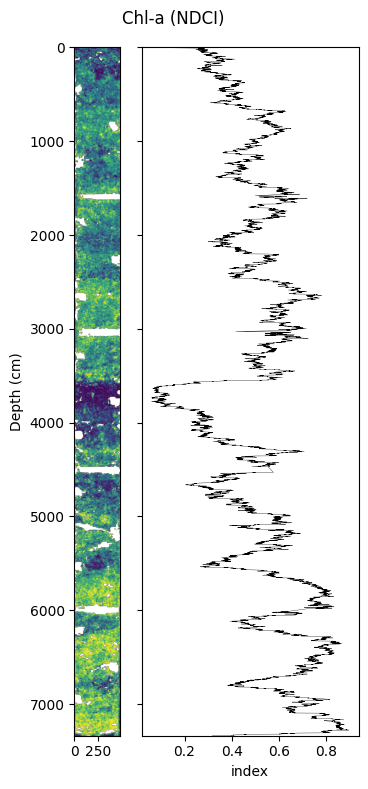

In [482]:
# scale
fig, axs = plot_index(ndci)
fig.suptitle('Chl-a (NDCI)')
plt.savefig("NDCI.png", dpi=300)

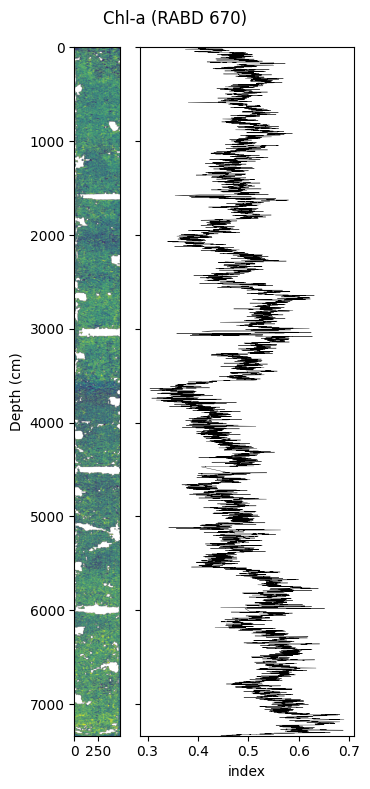

In [483]:
fig, axs = plot_index(chl_a)
fig.suptitle('Chl-a (RABD 670)')
plt.savefig("RABD670.png", dpi=300)

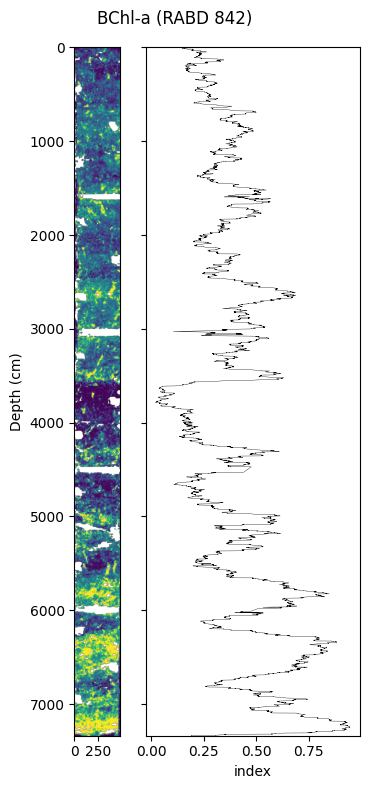

In [484]:
fig, axs = plot_index(bchl_a)
fig.suptitle('BChl-a (RABD 842)')
plt.savefig("RABD842.png", dpi=300)

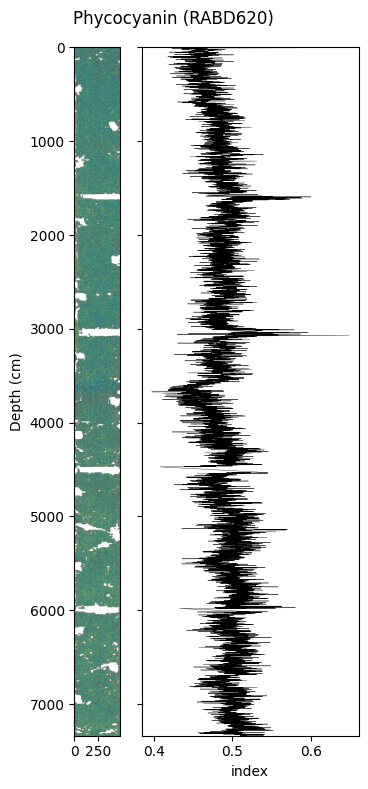

In [485]:
# scale
fig, axs = plot_index(phy)
fig.suptitle('Phycocyanin (RABD620)')
plt.savefig("RABD620.png", dpi=300)